## Melody Finder
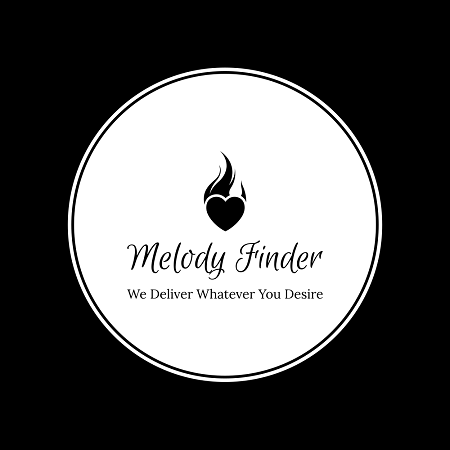



This project uses Google Colab Notebook to build a music recommendation based on user's liked songs. I used data from spotify to train the data, I used spotify's API as database to get similar songs. I used  K-Nearest Neighbors (KNN) algorithm to build a model that predicts similar songs based on Title of the song and the Year it was released.

This dataset can be gotten from the goggle drive link: https://drive.google.com/drive/folders/13vL6uLugW-6NpCSdxX4ZyodSyqwYEyAp?usp=sharing

In [ ]:
# Mount and connect to drive or wherever the dataset is located.
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
# importing library packages needed
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from yellowbrick.target import FeatureCorrelation
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Melody_Finder/dataset/data.csv')
genre_data = pd.read_csv('/content/drive/MyDrive/Melody_Finder/dataset/data_by_genres.csv')
year_data = pd.read_csv('/content/drive/MyDrive/Melody_Finder/dataset/data_by_year.csv')


In [ ]:
print(data.info())
print(genre_data.info())
print(year_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

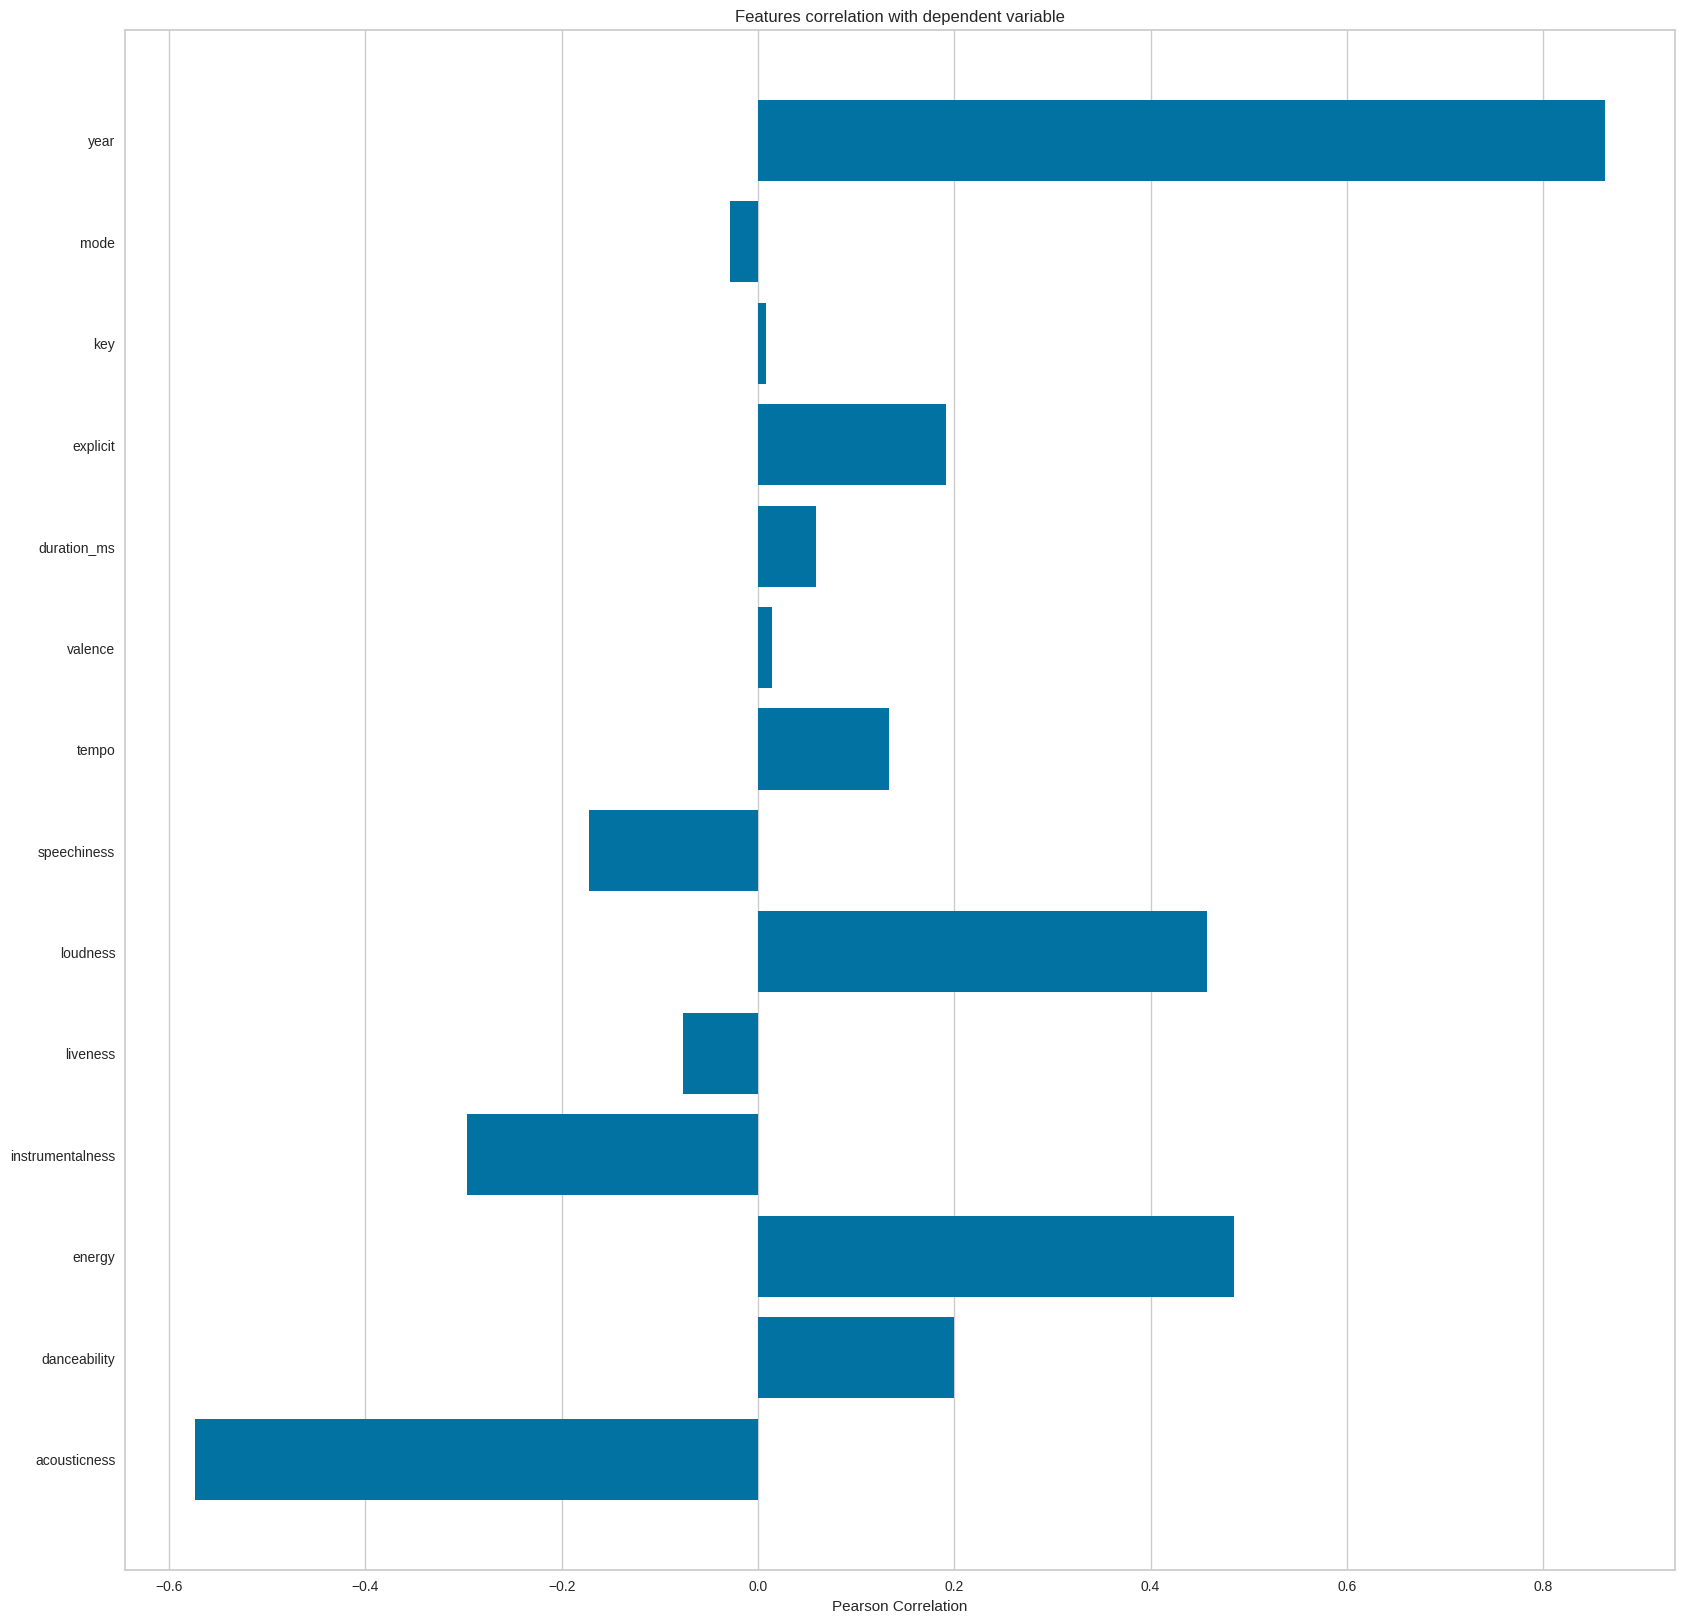

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']

X, y = data[feature_names], data['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

<Axes: xlabel='decade', ylabel='count'>

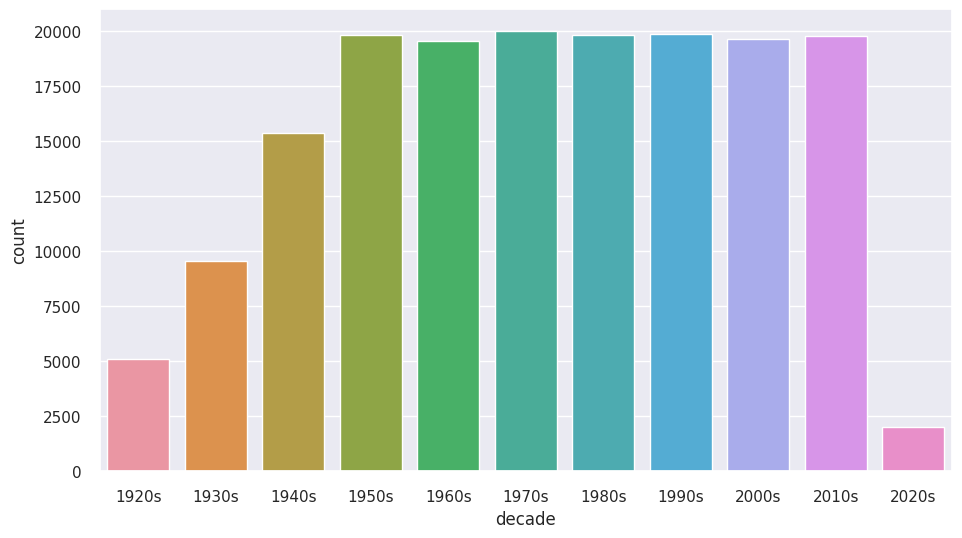

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade 
data['decade'] = data['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(data, x = 'decade')


In [ ]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']

fig = px.line(year_data, x='year', y=sound_features)
fig.show()

In [ ]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

In [ ]:

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [ ]:
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.007s...
[t-SNE] Computed neighbors for 2973 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.106171
[t-SNE] KL divergence after 1000 iterations: 1.392809


In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))
                                 ], verbose=False)
X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [ ]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

In [ ]:
# Set your Spotify API credentials
client_id = "5f28d6e025294504834977f1e7155c46"
client_secret = "c322f3e8a6e54f4d94d24664e51ce0ff"

# Create a Spotify client
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
def find_song(name, year):
    song_data = defaultdict(list)
    results = sp.search(q='track:"{}" year:{}'.format(name, year), limit=1)

    if results['tracks']['items'] == []:
        return pd.DataFrame()  # Return an empty DataFrame instead of None

    track = results['tracks']['items'][0]
    track_id = track['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'].extend([name])
    song_data['year'].extend([year])
    song_data['explicit'].extend([int(track['explicit'])])
    song_data['duration_ms'].extend([track['duration_ms']])
    song_data['popularity'].extend([track['popularity']])

    for key, value in audio_features.items():
        song_data[key].extend([value])  # Use extend to ensure arrays have the same length

    return pd.DataFrame(song_data)

In [ ]:
number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

In [ ]:
def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    except IndexError:
        return None

In [ ]:
def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    flattened_dict = defaultdict(list)
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
    return flattened_dict

In [ ]:
def recommend_songs( song_list, spotify_data, n_songs=10):
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
def recommender(song):
    rec_song = recommend_songs(song, data)
    return  rec_song

In [ ]:
a = [{'name':'Cry Me a River', 'year':2002}]
recommender(a)

[{'name': 'The Look', 'year': 2011, 'artists': "['Metronomy']"},
 {'name': 'Suga Suga', 'year': 2003, 'artists': "['Baby Bash', 'Frankie J']"},
 {'name': 'Secretos De Mi Memoria',
  'year': 1999,
  'artists': "['La Arrolladora Banda El Limón De Rene Camacho']"},
 {'name': 'Victoria', 'year': 2020, 'artists': "['Lunay', 'Beéle']"},
 {'name': '<3', 'year': 2020, 'artists': "['Bad Bunny']"},
 {'name': 'Let Me Love You', 'year': 2004, 'artists': "['Mario']"},
 {'name': 'Girl', 'year': 2004, 'artists': '["Destiny\'s Child"]'},
 {'name': 'Halo', 'year': 2008, 'artists': "['Beyoncé']"},
 {'name': 'Zun Da Da', 'year': 2007, 'artists': "['Zion']"}]

In [ ]:
pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=e1cb18bfee5932373a52f8efede1bacc49b64a1ae14db07a4d410231ed4701d2
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [ ]:
import anvil.server

anvil.server.connect("server_MWTSWGAQCZWG4KOSJGBAZZSU-WYXKS2VQDQOVBKMX")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Debug for deletella01@gmail.com" as SERVER


In [ ]:
@anvil.server.callable
def recommender(song):
    rec_song = print(song)
    #rec_song = recommend_songs(song, data)
    return  rec_song

In [ ]:
pip install nbconvert

In [29]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Melody_Finder/Melody Finder.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Melody_Finder/Melody Finder.ipynb to html
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/widgetsdatatypefilter.py:71: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn(
[NbConvertApp] Writing 988240 bytes to /content/drive/MyDrive/Melody_Finder/Melody Finder.html
